# Attention
1. This is the **second part of the Final Project notebook (including Extra Part 7-8)**.
1. This notebook **may not be able to be run all at once** because the default **memory and GPU resources provided by colab are not enough**, so in addition to this notebook, I have **divided it into two parts** so that testers can **directly run both notebooks separately** to see the results.
2. Also it will **take a long time** to run through all the content, please be patient, or people can **refer to the existing output** which is exactly the same as what you will get after running. Thanks!

# Prepare all the data needed (copied from the first part, not important and can be ignored)

In [1]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.12.0
Version 2, minor 12


In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
# Derived from: https://stackoverflow.com/a/44210735

import pkg_resources

required = {'scikit-learn'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [4]:
!pip install transformers
!pip install transformers[sentencepiece]
!pip install datasets
!pip install evaluate
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21

In [5]:
import transformers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import Dataset, DatasetDict
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizerFast, TFDistilBertModel
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops.gen_logging_ops import histogram_summary
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from transformers import get_scheduler
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
dataset_name = "financial_phrasebank"
subset_name = 'sentences_allagree'

label_to_int = { 'negative': 0, 'neutral': 1, 'positive': 2}

(text_hdr, label_hdr) = ("sentence", "label")

dataset = load_dataset(dataset_name, subset_name)['train']
dataset = dataset.shuffle()

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_allagree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
train_texts, test_texts, train_labels, test_labels = train_test_split(dataset["sentence"], dataset["label"], test_size=0.2)
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=0.25)

In [8]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
modelBert_distil = TFDistilBertModel.from_pretrained(checkpoint)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [9]:
train_tokens = tokenizer(train_texts, truncation=True, padding = True)
valid_tokens = tokenizer(valid_texts, truncation=True, padding = True)
test_tokens = tokenizer(test_texts, truncation=True, padding = True)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_tokens),
    train_labels
))
valid_dataset = tf.data.Dataset.from_tensor_slices((
    dict(valid_tokens),
    valid_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_tokens),
    test_labels
))

In [11]:
def train_model(model, train_dataset, valid_dataset, num_epochs=5):
    num_train_steps = len(train_dataset) * num_epochs
    lr_scheduler = PolynomialDecay(
        initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
    )

    model.compile(
        optimizer = Adam(learning_rate=lr_scheduler),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics = ["accuracy"]
    )

    res = model.fit(
      train_dataset.batch(8), 
      validation_data = valid_dataset.batch(8),
      epochs = num_epochs
    )

    return res

In [12]:
def eval_model(model, test_dataset, test_labels):
  test_logits = model.predict(test_dataset.batch(8))

  try:
    # If it is a Hugging Face return type, the logits are in the result attribute 'logits'
      test_logits = test_logits["logits"]
  except:
      pass
  
  test_preds = np.argmax(test_logits, axis=1)

  cf_matrix = confusion_matrix(test_labels, test_preds)
  # Plot confusion matrix
  sns.heatmap(cf_matrix, annot=True)

  res = classification_report(test_labels, test_preds, digits = 4)  
  
  return res

In [13]:
def hf2tfds(dataset, tokenizer):
    tokens = tokenizer(dataset["sentence"], padding=True, return_tensors="np")
    labels = np.array(dataset["label"])

    dataset_tf = tf.data.Dataset.from_tensor_slices((
          dict(tokens), 
          labels
        ))

    return dataset_tf

  
def tdfs_split(dataset_tf):
    # Split the dataset into training and validation datasets
    test_dataset_tf = dataset_tf.take(int(len(dataset) * 0.2))
    train_dataset_tf = dataset_tf.skip(int(len(dataset) * 0.2))

    valid_dataset_tf = train_dataset_tf.take(int(len(dataset) * 0.2))
    train_dataset_tf = train_dataset_tf.skip(int(len(dataset) * 0.2))

    return train_dataset_tf, valid_dataset_tf, test_dataset_tf

In [14]:
def train_model_TFDS(model, train_dataset_tf, valid_dataset_tf, num_epochs=5):

    num_train_steps = len(train_dataset_tf) * num_epochs
    lr_scheduler = PolynomialDecay(
        initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
    )

    model.compile(
        optimizer = Adam(learning_rate=lr_scheduler),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics = ["accuracy"]
    )

    res = model.fit(
      # Call shuffle and batch methods of TFDS
      train_dataset_tf.shuffle(1000).batch(8), 
      validation_data = valid_dataset_tf.batch(8),
      epochs = num_epochs
    )

    return res

In [15]:
dataset_tf = hf2tfds(dataset, tokenizer)
train_dataset_tf, valid_dataset_tf, test_dataset_tf = tdfs_split(dataset_tf)
test_labels_tf = np.array([y for x, y in test_dataset_tf])

In [28]:
dataset_name = "financial_phrasebank"
subset_name_50 = 'sentences_50agree'
subset_name_66 = 'sentences_66agree'
subset_name_75 = 'sentences_75agree'

dataset_50 = load_dataset(dataset_name, subset_name_50)['train'].shuffle()
dataset_66 = load_dataset(dataset_name, subset_name_66)['train'].shuffle()
dataset_75 = load_dataset(dataset_name, subset_name_75)['train'].shuffle()

dataset_tf_50 = hf2tfds(dataset_50, tokenizer)
train_dataset_tf_50, valid_dataset_tf_50, test_dataset_tf_50 = tdfs_split(dataset_tf_50)
test_labels_tf_50 = np.array([y for x, y in test_dataset_tf_50])

dataset_tf_66 = hf2tfds(dataset_66, tokenizer)
train_dataset_tf_66, valid_dataset_tf_66, test_dataset_tf_66 = tdfs_split(dataset_tf_66)
test_labels_tf_66 = np.array([y for x, y in test_dataset_tf_66])

dataset_tf_75 = hf2tfds(dataset_75, tokenizer)
train_dataset_tf_75, valid_dataset_tf_75, test_dataset_tf_75 = tdfs_split(dataset_tf_75)
test_labels_tf_75 = np.array([y for x, y in test_dataset_tf_75])

del dataset_50
del dataset_66
del dataset_75

Generating train split:   0%|          | 0/4846 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/4217 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_66agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset financial_phrasebank downloaded and prepared to /root/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

# Extras (continued)

## 7.Experiment with Fine-Tuning

*Relative difficulty*: low, but time-consuming

Does out of sample performance vary with changing
- the number of examples in Fine-Tuning
    - what is the smallest number that you think is sufficient
- **there are many choices of proper subsets of a given size**
    - **does it matter which one you choose ?**

### Different numbers of examples
- In this session, we try to compare the performance of models with different numbers of training dataset. Here for simplification, we only set three levels which are 400, 800 and 1200. Then we will compare the performance and see if there is significant difference between the results and estimate the smallest but sufficient number of traianing examples.

In [16]:
train_dataset_tf_400 = train_dataset_tf.shuffle(len(dataset), seed=42).take(400).prefetch(tf.data.AUTOTUNE)
train_dataset_tf_800 = train_dataset_tf.shuffle(len(dataset), seed=42).take(800).prefetch(tf.data.AUTOTUNE)
train_dataset_tf_1200 = train_dataset_tf.shuffle(len(dataset), seed=42).take(1200).prefetch(tf.data.AUTOTUNE)

#### Use 400 training examples

In [17]:
modelFined_auto_400 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

train_model_TFDS(modelFined_auto_400, train_dataset_tf_400, valid_dataset_tf)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_38']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
50/50 [==============================] - 47s 339ms/step - loss: 0.7044 - accuracy: 0.6750 - val_loss: 0.4693 - val_accuracy: 0.8208
Epoch 2/5
50/50 [==============================] - 13s 259ms/step - loss: 0.2992 - accuracy: 0.8975 - val_loss: 0.3787 - val_accuracy: 0.8872
Epoch 3/5
50/50 [==============================] - 11s 222ms/step - loss: 0.2018 - accuracy: 0.9300 - val_loss: 0.2467 - val_accuracy: 0.9314
Epoch 4/5
50/50 [==============================] - 11s 209ms/step - loss: 0.1788 - accuracy: 0.9475 - val_loss: 0.3126 - val_accuracy: 0.9004
Epoch 5/5
50/50 [==============================] - 10s 207ms/step - loss: 0.1191 - accuracy: 0.9750 - val_loss: 0.1793 - val_accuracy: 0.9447


57/57 [==============================] - 4s 46ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/400) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9831    0.9508    0.9667        61
           1     0.9748    0.9927    0.9837       273
           2     0.9739    0.9492    0.9614       118

    accuracy                         0.9757       452
   macro avg     0.9773    0.9642    0.9706       452
weighted avg     0.9757    0.9757    0.9756       452



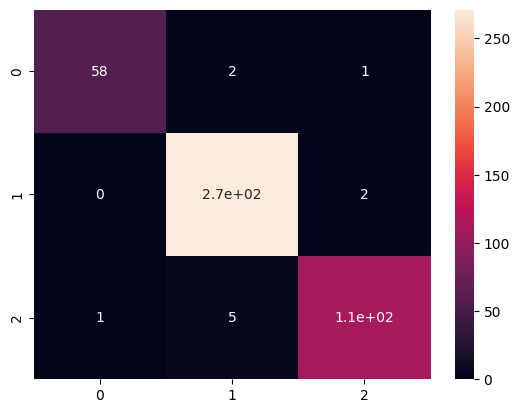

In [18]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/400) | Without Resampling]\nResult:\n" , eval_model(modelFined_auto_400, test_dataset_tf, test_labels_tf))

In [19]:
del train_dataset_tf_400
del modelFined_auto_400

#### Use 800 training examples

In [20]:
modelFined_auto_800 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

train_model_TFDS(modelFined_auto_800, train_dataset_tf_800, valid_dataset_tf)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_58', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
100/100 [==============================] - 46s 237ms/step - loss: 0.5484 - accuracy: 0.7600 - val_loss: 0.3317 - val_accuracy: 0.8916
Epoch 2/5
100/100 [==============================] - 20s 205ms/step - loss: 0.2083 - accuracy: 0.9337 - val_loss: 0.2542 - val_accuracy: 0.9093
Epoch 3/5
100/100 [==============================] - 17s 170ms/step - loss: 0.1208 - accuracy: 0.9688 - val_loss: 0.2017 - val_accuracy: 0.9292
Epoch 4/5
100/100 [==============================] - 17s 170ms/step - loss: 0.0707 - accuracy: 0.9812 - val_loss: 0.2639 - val_accuracy: 0.9093
Epoch 5/5
100/100 [==============================] - 20s 196ms/step - loss: 0.0567 - accuracy: 0.9837 - val_loss: 0.2294 - val_accuracy: 0.9336


57/57 [==============================] - 4s 46ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/800) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     1.0000    0.9180    0.9573        61
           1     0.9713    0.9927    0.9819       273
           2     0.9573    0.9492    0.9532       118

    accuracy                         0.9712       452
   macro avg     0.9762    0.9533    0.9641       452
weighted avg     0.9715    0.9712    0.9711       452



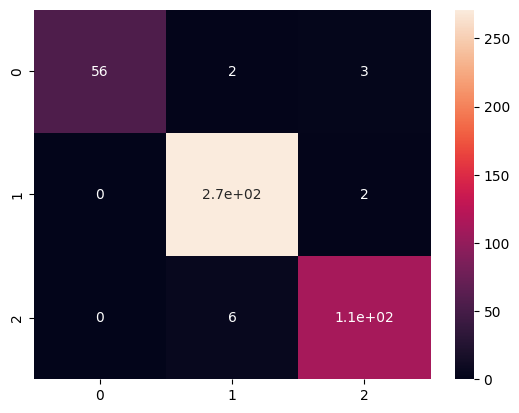

In [21]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/800) | Without Resampling]\nResult:\n" , eval_model(modelFined_auto_800, test_dataset_tf, test_labels_tf))

In [22]:
del train_dataset_tf_800
del modelFined_auto_800

#### Use 1200 training examples

In [23]:
modelFined_auto_1200 = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

train_model_TFDS(modelFined_auto_1200, train_dataset_tf_1200, valid_dataset_tf)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_78', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Epoch 1/5
150/150 [==============================] - 55s 209ms/step - loss: 0.3924 - accuracy: 0.8450 - val_loss: 0.3045 - val_accuracy: 0.8872
Epoch 2/5
150/150 [==============================] - 24s 163ms/step - loss: 0.1440 - accuracy: 0.9608 - val_loss: 0.2484 - val_accuracy: 0.9270
Epoch 3/5
150/150 [==============================] - 26s 172ms/step - loss: 0.0804 - accuracy: 0.9742 - val_loss: 0.2381 - val_accuracy: 0.9336
Epoch 4/5
150/150 [==============================] - 26s 173ms/step - loss: 0.0518 - accuracy: 0.9817 - val_loss: 0.4920 - val_accuracy: 0.8584
Epoch 5/5
150/150 [==============================] - 23s 153ms/step - loss: 0.0313 - accuracy: 0.9917 - val_loss: 0.2742 - val_accuracy: 0.9314


57/57 [==============================] - 5s 51ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/1200) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9821    0.9016    0.9402        61
           1     0.9711    0.9853    0.9782       273
           2     0.9412    0.9492    0.9451       118

    accuracy                         0.9646       452
   macro avg     0.9648    0.9454    0.9545       452
weighted avg     0.9648    0.9646    0.9644       452



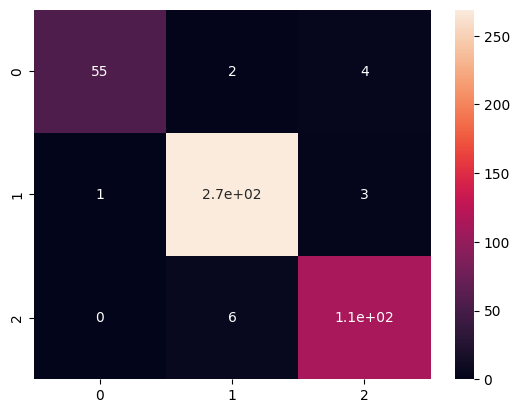

In [24]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | All-Agree Dataset(TFDS/1200) | Without Resampling]\nResult:\n" , eval_model(modelFined_auto_1200, test_dataset_tf, test_labels_tf))

In [25]:
del train_dataset_tf_1200
del modelFined_auto_1200

#### Conclusion
- The models perform better with more training samples.
- The accuracies of models trained on 400 samples and 800 samples are both around 0.94, but it jumps to 0.95 when the number of samples comes to 1200. This may indicate **the smallest number that is sufficient to make the accuracy above 0.95 is between 800 and 1200, let's say 1000 is an appropriate number.**

### Different subsets of a given size
- From the last session, we have found that more training examples lead to higher accuracy, and we have found the sufficient number for a 0.95 accuracy is around 1000.
- Given the three subsets (all-agree/50-agree/66-agree/75-agree), it's better to use as many examples as we can to train the models. Therefore, we will find the minumum size of the three subsets and truncate all the three subsets to that size (larger than 1000), and then compare the performance of models trained on each subset with the same size.

In [29]:
size = min(len(dataset_tf_50), len(dataset_tf_66), len(dataset_tf_75), len(dataset_tf))

dataset_tf_50GS = dataset_tf_50.take(size)
dataset_tf_66GS = dataset_tf_66.take(size)
dataset_tf_75GS = dataset_tf_75.take(size)
dataset_tf_allGS = dataset_tf.take(size)

train_dataset_tf_50GS, valid_dataset_tf_50GS, test_dataset_tf_50GS = tdfs_split(dataset_tf_50GS)
test_labels_tf_50GS = np.array([y for x, y in test_dataset_tf_50GS])

train_dataset_tf_66GS, valid_dataset_tf_66GS, test_dataset_tf_66GS = tdfs_split(dataset_tf_66GS)
test_labels_tf_66GS = np.array([y for x, y in test_dataset_tf_66GS])

train_dataset_tf_75GS, valid_dataset_tf_75GS, test_dataset_tf_75GS = tdfs_split(dataset_tf_75GS)
test_labels_tf_75GS = np.array([y for x, y in test_dataset_tf_75GS])

train_dataset_tf_allGS, valid_dataset_tf_allGS, test_dataset_tf_allGS = tdfs_split(dataset_tf_allGS)
test_labels_tf_allGS = np.array([y for x, y in test_dataset_tf_allGS])

del dataset_tf_50GS
del dataset_tf_66GS
del dataset_tf_75GS
del dataset_tf_allGS

#### Create models

In [30]:
modelFined_50GS = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_66GS = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_75GS = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
modelFined_allGS = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_98']
You should probably TRAIN this model on a down-stream task to be able to use i

#### Use 50-agree dataset of a given size

In [31]:
train_model_TFDS(modelFined_50GS, train_dataset_tf_50GS, valid_dataset_tf_50GS)

Epoch 1/5
170/170 [==============================] - 63s 233ms/step - loss: 0.6475 - accuracy: 0.7397 - val_loss: 0.5030 - val_accuracy: 0.8164
Epoch 2/5
170/170 [==============================] - 27s 160ms/step - loss: 0.3009 - accuracy: 0.8890 - val_loss: 0.5495 - val_accuracy: 0.8186
Epoch 3/5
170/170 [==============================] - 27s 159ms/step - loss: 0.1495 - accuracy: 0.9551 - val_loss: 0.6510 - val_accuracy: 0.8208
Epoch 4/5
170/170 [==============================] - 26s 155ms/step - loss: 0.0825 - accuracy: 0.9772 - val_loss: 0.7011 - val_accuracy: 0.8053
Epoch 5/5
170/170 [==============================] - 26s 152ms/step - loss: 0.0835 - accuracy: 0.9765 - val_loss: 0.6751 - val_accuracy: 0.8208


57/57 [==============================] - 5s 53ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 50-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.8545    0.8704    0.8624        54
           1     0.8419    0.8419    0.8419       253
           2     0.7431    0.7379    0.7405       145

    accuracy                         0.8119       452
   macro avg     0.8132    0.8167    0.8149       452
weighted avg     0.8117    0.8119    0.8118       452



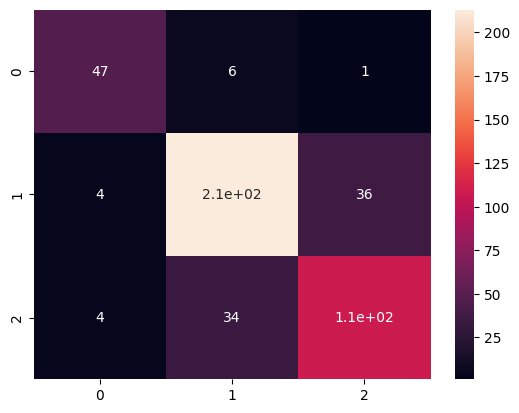

In [32]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 50-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_50GS, test_dataset_tf_50GS, test_labels_tf_50GS))

In [33]:
del modelFined_50GS

#### Use 66-agree dataset of a given size

In [34]:
train_model_TFDS(modelFined_66GS, train_dataset_tf_66GS, valid_dataset_tf_66GS)

Epoch 1/5
170/170 [==============================] - 61s 218ms/step - loss: 0.5821 - accuracy: 0.7654 - val_loss: 0.4318 - val_accuracy: 0.8341
Epoch 2/5
170/170 [==============================] - 28s 162ms/step - loss: 0.2670 - accuracy: 0.9110 - val_loss: 0.3980 - val_accuracy: 0.8650
Epoch 3/5
170/170 [==============================] - 26s 154ms/step - loss: 0.1341 - accuracy: 0.9559 - val_loss: 0.6652 - val_accuracy: 0.8075
Epoch 4/5
170/170 [==============================] - 26s 153ms/step - loss: 0.0974 - accuracy: 0.9699 - val_loss: 0.5521 - val_accuracy: 0.8540
Epoch 5/5
170/170 [==============================] - 26s 154ms/step - loss: 0.0501 - accuracy: 0.9860 - val_loss: 0.5812 - val_accuracy: 0.8584


57/57 [==============================] - 4s 46ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 66-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.7857    0.8627    0.8224        51
           1     0.9007    0.9203    0.9104       276
           2     0.8596    0.7840    0.8201       125

    accuracy                         0.8761       452
   macro avg     0.8487    0.8557    0.8510       452
weighted avg     0.8764    0.8761    0.8755       452



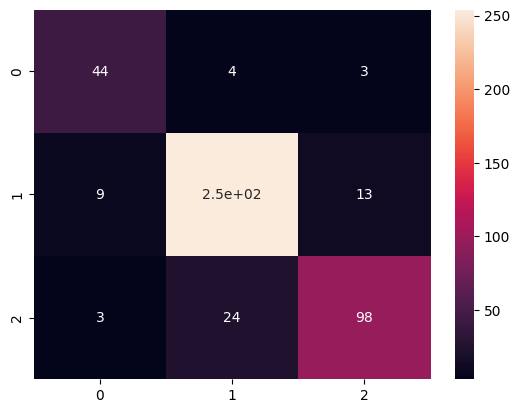

In [35]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 66-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_66GS, test_dataset_tf_66GS, test_labels_tf_66GS))

In [36]:
del modelFined_66GS

#### Use 75-agree dataset of a given size

In [37]:
train_model_TFDS(modelFined_75GS, train_dataset_tf_75GS, valid_dataset_tf_75GS)

Epoch 1/5
170/170 [==============================] - 59s 209ms/step - loss: 0.4877 - accuracy: 0.8169 - val_loss: 0.3128 - val_accuracy: 0.9049
Epoch 2/5
170/170 [==============================] - 28s 162ms/step - loss: 0.2005 - accuracy: 0.9301 - val_loss: 0.2468 - val_accuracy: 0.9226
Epoch 3/5
170/170 [==============================] - 26s 154ms/step - loss: 0.0928 - accuracy: 0.9735 - val_loss: 0.3059 - val_accuracy: 0.9115
Epoch 4/5
170/170 [==============================] - 26s 154ms/step - loss: 0.0435 - accuracy: 0.9875 - val_loss: 0.3712 - val_accuracy: 0.8916
Epoch 5/5
170/170 [==============================] - 26s 151ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.3798 - val_accuracy: 0.9115


57/57 [==============================] - 4s 46ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     0.9444    0.8361    0.8870        61
           1     0.9403    0.9368    0.9385       269
           2     0.8385    0.8934    0.8651       122

    accuracy                         0.9115       452
   macro avg     0.9077    0.8888    0.8969       452
weighted avg     0.9134    0.9115    0.9118       452



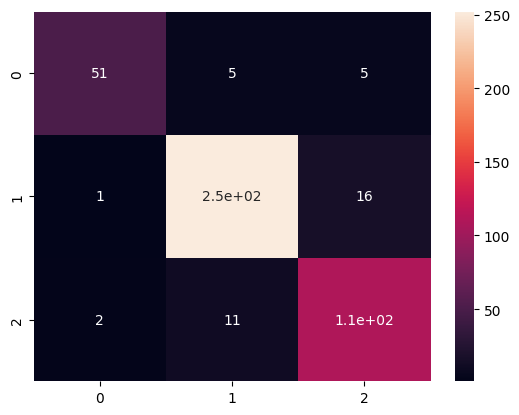

In [38]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_75GS, test_dataset_tf_75GS, test_labels_tf_75GS))

In [39]:
del modelFined_75GS

#### Use All-agree dataset of a given size



In [40]:
train_model_TFDS(modelFined_allGS, train_dataset_tf_allGS, valid_dataset_tf_allGS)

Epoch 1/5
170/170 [==============================] - 59s 205ms/step - loss: 0.3907 - accuracy: 0.8375 - val_loss: 0.2100 - val_accuracy: 0.9358
Epoch 2/5
170/170 [==============================] - 28s 164ms/step - loss: 0.1059 - accuracy: 0.9632 - val_loss: 0.2688 - val_accuracy: 0.9071
Epoch 3/5
170/170 [==============================] - 26s 152ms/step - loss: 0.0459 - accuracy: 0.9853 - val_loss: 0.1813 - val_accuracy: 0.9491
Epoch 4/5
170/170 [==============================] - 26s 151ms/step - loss: 0.0358 - accuracy: 0.9890 - val_loss: 0.3758 - val_accuracy: 0.9248
Epoch 5/5
170/170 [==============================] - 26s 151ms/step - loss: 0.0343 - accuracy: 0.9853 - val_loss: 0.2401 - val_accuracy: 0.9403


57/57 [==============================] - 5s 48ms/step

Config: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]
Result:
               precision    recall  f1-score   support

           0     1.0000    0.9508    0.9748        61
           1     0.9713    0.9927    0.9819       273
           2     0.9652    0.9407    0.9528       118

    accuracy                         0.9735       452
   macro avg     0.9788    0.9614    0.9698       452
weighted avg     0.9736    0.9735    0.9733       452



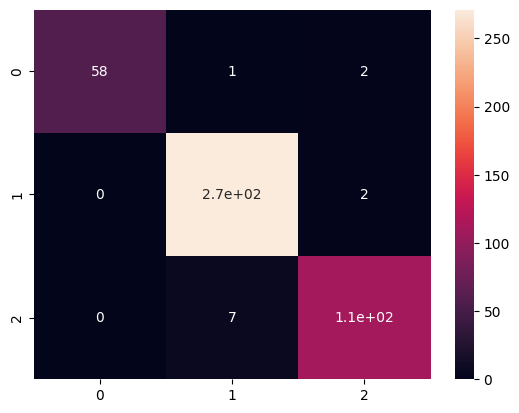

In [41]:
print("\nConfig: [Distilbert-base-uncased | Auto Head | Train All Layers | 75-Agree Dataset(TFDS) | Without Resampling]\nResult:\n", eval_model(modelFined_allGS, test_dataset_tf_allGS, test_labels_tf_allGS))

In [42]:
del modelFined_allGS

#### Conclusion
- Comparing the above results, we can get the same conclusion as that in the 'Use different flavors of the dataset' part. The higher the level of agreement is, the higher the accuracy will be.
- Using only 1000 number of examples, the accuracies are a bit lower than using all the examples (refer to results in the 'Use different flavors of the dataset' part). However, it is still satisfying in that we can get about the same results with a much smaller data set, which saves time and computing resources.
- This further verifies that '1000' is a suitable small number which is sufficient in our fine-tuning process.

## 8.In-context learning

*Relative difficulty: low but fun !*

Can you use few-shot learning successfully (i.e., no further training) ?

It would be great to do this for Financial PhraseBank but the sentences may be too long
- pre-trained models have maximum sequence lengths that may be too small

**Propose some interesting task related to Finance and try to achieve Few Shot Learning on the task.**

In [43]:
from transformers import pipeline
from transformers import GPTNeoForCausalLM

### Sentiment Analysis
- Same as the task of this project, we try to use in-context learning to classify if the input sentence is negative, neutral or positive. 
- Here we directly apply the classifier based on "facebook/bart-large-mnli" to some examples in the test_dataset we created before.

In [44]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [56]:
import random

few_shot_preds = []
label_map = {'negative':0, 'neutral':1, 'positive':2}
candidate_labels = ['negative', 'neutral', 'positive']

random.seed(2)
index = [random.randint(0, len(test_dataset)) for _ in range(10)]

for i in index: 
  sentence = test_texts[i]
  pred = label_map[classifier(sentence, candidate_labels)['labels'][0]]
  print('Sentence: {}\nTrue label: {}. Predicted label: {}\n'.format(sentence, test_labels[i], pred))

Sentence: Kalnapilio-Tauro Grupe ( Kalnapilis-Tauras Group ) , which is owned by Denmark 's Royal Unibrew , raised its market share to 25.18 percent from 23.74 percent , as beer sales for the seven months jumped by 14.5 percent to 40.5 million liters .
True label: 2. Predicted label: 2

Sentence: Finnlines will announce in week 17 of 2006 what measures it will take to tackle the situation .
True label: 1. Predicted label: 0

Sentence: 26 January 2011 - Finnish metal products company Componenta Oyj ( HEL : CTH1V ) said yesterday its net loss narrowed to EUR500 ,000 in the last quarter of 2010 from EUR5 .3 m for the same period a year earlier .
True label: 2. Predicted label: 0

Sentence: Total value of the contract is about EUR 10mn .
True label: 1. Predicted label: 2

Sentence: Unbelievably , the company that makes them - Fiskars Corporation - was formed in 1649 when a Dutch merchant named Peter Thorwoste was given a charter to establish a blast furnace and forging operation in the sma

### Topic Classification
- Besides sentiment analysis, I think it's a good idea to implement topic classification with the help of in-context learning. **According to The Wall Street Journal, articles usually belong to one of the following sections: Politics, Economy, Businuss, Tech, Markets. Therefore, I want to find if few-shot learning can help classify a given sentence correctly to the real topic it belongs to. 
- To verify this, I randomly select some sentences from various sections in Wall Street Journal, most of which are article titles, as input of the model, and check the results respectively.

In [57]:
test_pool = {"A Debt Deal Could Help Solve the Country’s Inflation Problem": "economy",
             "Eight Trump Electors Granted Immunity in Georgia Investigation": "politics",
             "How Big Companies Choose Who Is Laid Off": 'business',
             "Forget ChatGPT. These Are the Best AI-Powered Apps.": "technology",
             "Investors Flock to Safety Plays, but Stock ‘FOMO’ Lingers": 'market'}
candidate_labels = ['politics', 'economy', 'business', 'technology', 'market']

In [58]:
for sentence in test_pool.keys():
    print('Sentence: {}\nTrue topic: {}. Top 3 predicted topics: {}\n'.format(sentence, test_pool[sentence],classifier(sentence, candidate_labels)['labels'][:3]))

Sentence: A Debt Deal Could Help Solve the Country’s Inflation Problem
True topic: economy. Top 3 predicted topics: ['economy', 'market', 'business']

Sentence: Eight Trump Electors Granted Immunity in Georgia Investigation
True topic: politics. Top 3 predicted topics: ['politics', 'market', 'business']

Sentence: How Big Companies Choose Who Is Laid Off
True topic: business. Top 3 predicted topics: ['business', 'economy', 'market']

Sentence: Forget ChatGPT. These Are the Best AI-Powered Apps.
True topic: technology. Top 3 predicted topics: ['technology', 'market', 'business']

Sentence: Investors Flock to Safety Plays, but Stock ‘FOMO’ Lingers
True topic: market. Top 3 predicted topics: ['market', 'business', 'economy']



- We can see the result is quite good!
- Then we try to implement this classifier to some of the sentences in Financial Bankphrase dataset just for fun!

In [59]:
test_pool_fin = test_texts[:10]

for sentence in test_pool_fin:
  print('Sentence: {}\nTop 3 predicted topics: {}\n'.format(sentence,classifier(sentence, candidate_labels)['labels'][:3]))


Sentence: Please inform IR Johanna Koskinen of your participation no later than 20 April at 10 a.m. A telephone conference for financial analysts and investors , conducted in English , will begin at 3:00 p.m. Finnish time ( EET ) .
Top 3 predicted topics: ['business', 'market', 'economy']

Sentence: A 2001 agreement expired earlier this month .
Top 3 predicted topics: ['business', 'market', 'economy']

Sentence: The company said that 80 % of the shares of the holding company will be sold to Meadville Holdings Limited , a Hong Kong listed parent company of the Meadville Group .
Top 3 predicted topics: ['business', 'market', 'economy']

Sentence: The scheme for TeliaSonera and Altimo is practically identical , except that it involves the merger of their stakes in VimpelCom and Kyivstar .
Top 3 predicted topics: ['market', 'business', 'technology']

Sentence: The closing of the transaction is scheduled to take place on January 10 , 2008 .
Top 3 predicted topics: ['business', 'market', 'ec

- From the results, we can find 'business', 'market' and 'economy' are the closest three topics. This is reasonable because the dataset itself is about the sentences from financial news, which is mostly related to these topics.

In [61]:
print("Part 2 Done")

Part 2 Done
